In [1]:
import os, sys
sys.path.append('..')
from os.path import abspath, dirname
import zarr
import z5py
import numpy as np
import pandas as pd
from glob import glob 
from skimage.measure import regionprops
from skimage.io import imread, imsave
from scipy import stats
from scipy.stats import skewnorm, lognorm
from scipy.optimize import minimize
import itertools

from easi_fish import n5_metadata_utils as n5mu
from easi_fish import roi_prop, spot, intensity
import warnings
warnings.filterwarnings('ignore')

import importlib
importlib.reload(spot)
importlib.reload(roi_prop)
importlib.reload(intensity)

<module 'easi_fish.intensity' from '/u/project/zipursky/f7xiesnm/code/easifish-proc/data_processing/../easi_fish/intensity.py'>

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

Spot counts for cells with highly expressed genes (dense spots)
1. Measure total intensity of every ROI after bleed-through correction and background subtraction.
2. Calculate the number of spot from total intensity based on unit-spot intensity
3. Correlate the number of spots (from air-localize) with the total fluorescence intensity/voxel in each ROI and determine a 'cutoff'. 
   Spot count > cutoff: use spot count converted based on total fluorescence intensity; 
   Spot count < cutoff: use spot count from Airlocalize

### On units
- all images are based on pixel units - 
- roi meta file (output) are based on physical unit (um - pre-expansion)
- spots files are in um (post-expansion)

In [3]:
## input
theround = 'r1'
rounds = [theround]
channels = ['c0'] #, 'c1', 'c2', 'c4']
lb_scale = 's3'
lb_res = [1.84,1.84,1.68]
ex = 2

ddir = '/u/home/f/f7xiesnm/project-zipursky/easifish/lt186'
output_dir = ddir + '/proc'

rdir = ddir + f"/outputs/{theround}"

# fixed image
fix_dir = rdir + "/stitching/export.n5"
subpath='/c3/s3' 

# segmentation mask (tif format accepted here)
lb_dir  = rdir + f"/segmentation/{theround}-c3.tif"

# spot dir for every gene
fx_spots = [rdir + f'/test_v0/spots/spots_{c}.txt' 
                for c in channels]
fx_intns = [rdir + f'/test_v0/intensities/{theround}_{c}_intensity.csv' 
                for c in channels]

for f in fx_spots:
    assert os.path.isfile(f)
for f in fx_intns:
    assert os.path.isfile(f)

## output
out_badroi = os.path.join(output_dir, 'bad_roi_list.npy')
out_allroi = os.path.join(output_dir, "roi_all.csv") 
out_roi = os.path.join(output_dir, "roi.csv") 
out_spots = os.path.join(output_dir, "spotcount.csv")
out_spots_intn = os.path.join(output_dir, "spotcount_intn.csv")
out_spots_merged = os.path.join(output_dir, 'spotcount_merged.csv')

In [4]:
REMOVE_BLEEDTHRU = False

# remove bleed through!
if REMOVE_BLEEDTHRU:
    
    bleed_thru_epsilon = 1
    c_qry = 'c0'
    c_ref = 'c4'

    f_ref = rdir+f'/spots/spots_{c_ref}.txt'
    f_qry = rdir+f'/spots/spots_{c_qry}.txt'
    f_qry_kept = os.path.join(output_dir, f'kept_spots_{c_qry}.txt')

    ref_dots = np.loadtxt(f_ref, delimiter=',')
    qry_dots = np.loadtxt(f_qry, delimiter=',')
    qry_kept, qry_removed = spot.remove_bleed_thru_spots(ref_dots, qry_dots, epsilon=bleed_thru_epsilon)

    # save 
    np.savetxt(f_qry_kept, qry_kept, delimiter=",")
    
    ### TODO - replace f_qry with f_qry_kept in spot list

In [5]:
%%time
# output dir
if not os.path.isdir(output_dir):
    print(output_dir)
    os.mkdir(output_dir)
    
# image size in pixel (x, y, z)
grid = n5mu.read_voxel_grid(fix_dir, subpath)
# voxel resolution in µm (x, y, z) (post-expansion)
vox  = n5mu.read_voxel_spacing(fix_dir, subpath)
# image size in physical space (x, y, z) (post-expansion)
size = grid*vox
print('subpath: ', subpath)
print('voxel size: ', vox)
print('image size (pixel): ', grid)
print('image size (um post-ex): ', size)

# get image data
# print("loading images...")
# fix = zarr.open(store=zarr.N5Store(fix_dir), mode='r')     
# img1 = fix[subpath][:, :, :]

# get seg
lb = imread(lb_dir)
roi = np.max(lb)
print(lb.shape)
print('num roi: ', roi)

# mask=np.full((grid[2], grid[1], grid[0]),1)
# for reg_dir in reg_dirs:
#     reg = zarr.open(store=zarr.N5Store(reg_dir), mode='r')     
#     img2 = reg[subpath][:, :, :]
#     print("image loaded")
#     mask[img2==0]=0
    
# # imsave(out_mask, mask)
# print("mask generated")
# print("mask dimension is:", mask.shape)

# # # Get list of ROIs that are fully or partially outside the mask 
# ### Make sure to only include ROIs that are intact and in the overlapping regions across all rounds of FISH
# bad_roi=np.unique(lb[mask==0])
# if bad_roi[0] == 0:
#     bad_roi = bad_roi[1:]
# np.save(out_badroi, bad_roi)
# print("# of ROIs rejected:", len(bad_roi))

subpath:  /c3/s3
voxel size:  [1.84 1.84 1.68]
image size (pixel):  [1131  913  648]
image size (um post-ex):  [2081.04 1679.92 1088.64]
(648, 913, 1131)
num roi:  28228
CPU times: user 7.39 s, sys: 3.25 s, total: 10.6 s
Wall time: 4.47 s


In [6]:
%%time
# get cell locations (in um - pre-expansion) from segmentation mask
roi_meta_all = roi_prop.roi_prop_v2(lb, lb_res, ex)
roi_meta_all.to_csv(out_allroi)

roi_meta = roi_meta_all.set_index('roi').copy()
roi_meta = roi_meta #.loc[roi_meta.index.difference(bad_roi)]
roi_meta.to_csv(out_roi)

CPU times: user 17.6 s, sys: 2.77 s, total: 20.3 s
Wall time: 21.3 s


In [7]:
%%time

# count spots for every cell (roi)

# all labels
lb_id = np.unique(lb[lb!=0]) # exclude 0
lb_id = np.hstack([[0], lb_id]) # include 0 - noncell
# selected cells
lb_id_selected = roi_meta.index.values

# prep
spotcount = pd.DataFrame(index=lb_id_selected, dtype=int)
spotcount_intn = pd.DataFrame(index=lb_id_selected, dtype=float)

for i, (r, c) in enumerate(itertools.product(rounds, channels)):
    f_intns = fx_intns[i]
    f_spots = fx_spots[i]
    print(r, c, f_spots, f_intns)
    
    # spots
    spots_rc = np.loadtxt(f_spots, delimiter=',')
    
    # filter
    # spots_rc = spots_rc[spots_rc[:,3] > 200]
        
    # count spots
    res = spot.spot_counts_worker(lb, spots_rc, lb_res,
                                  lb_id=lb_id, 
                                  remove_noncell=True, 
                                  selected_roi_list=lb_id_selected,
                                  )
    spotcount[f"{r}_{c}"] = res 
    
    # count spots by intensity
    res = spot.get_spot_counts_from_intn(f_intns, f_spots, roi_meta, lb_res)
    spotcount_intn[f'{r}_{c}'] = res
    
# save results
spotcount.to_csv(out_spots)
spotcount_intn.to_csv(out_spots_intn)

r1 c0 /u/home/f/f7xiesnm/project-zipursky/easifish/lt186/outputs/r1/test_v0/spots/spots_c0.txt /u/home/f/f7xiesnm/project-zipursky/easifish/lt186/outputs/r1/test_v0/intensities/r1_c0_intensity.csv
removed 0 spots due to nan
132,682/132,682 spots in range (1131, 913, 648)
CPU times: user 6.53 s, sys: 2.05 s, total: 8.58 s
Wall time: 8.69 s


In [8]:
# reconcile two spot counts
dist_cutoff = 2 # um pre-expansion
density = spotcount.divide(roi_meta['area'], axis=0)
cond = density < 1/(dist_cutoff**3) # keep spots if density is low

print("# cells have high density: ", (~cond).sum()) 
spotcount_merged = spotcount.where(cond, spotcount_intn)  # replace where the condition is False
spotcount_merged.to_csv(out_spots_merged)
spotcount_merged

# cells have high density:  r1_c0    1
dtype: int64


r1_c0
1       27.0
2       65.0
3        1.0
4        0.0
5        2.0
...      ...
28224    0.0
28225    0.0
28226    0.0
28227    0.0
28228    0.0

[28228 rows x 1 columns]

# check

<Axes: ylabel='Count'>

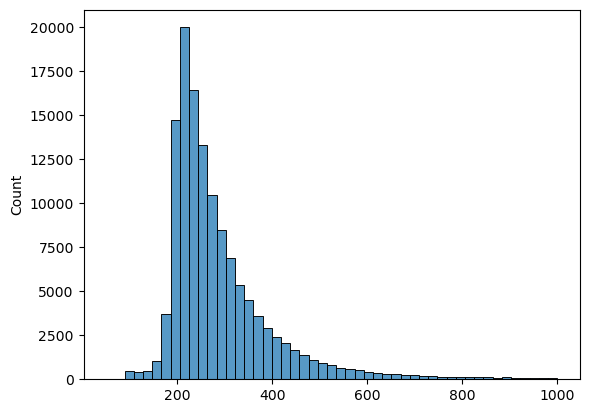

In [9]:
sns.histplot(spots_rc[:,3], bins=np.linspace(50,1000,50))

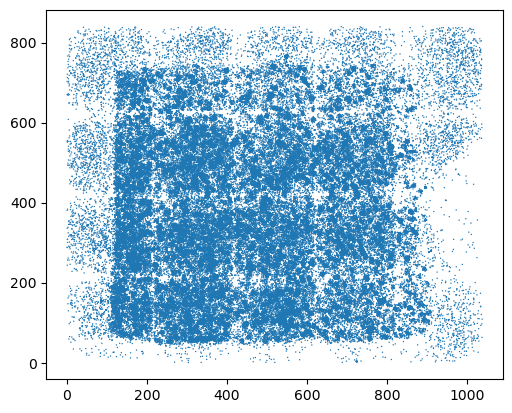

In [10]:
plt.scatter(spots_rc[:,0]/ex, spots_rc[:,1]/ex, s=1, edgecolor='none')
plt.gca().set_aspect('equal')

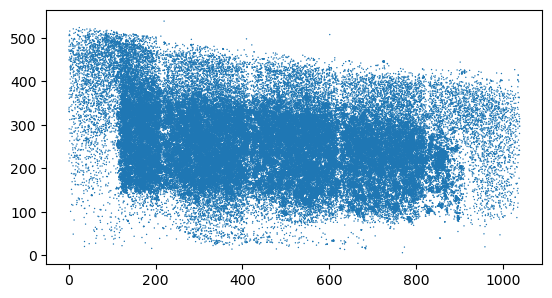

In [11]:
plt.scatter(spots_rc[:,0]/ex, spots_rc[:,2]/ex, s=1, edgecolor='none')
plt.gca().set_aspect('equal')

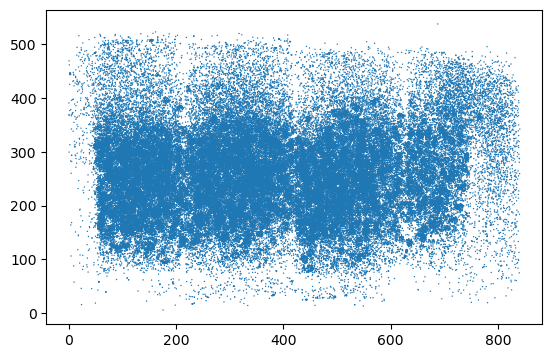

In [12]:
plt.scatter(spots_rc[:,1]/ex, spots_rc[:,2]/ex, s=1, edgecolor='none')
plt.gca().set_aspect('equal')

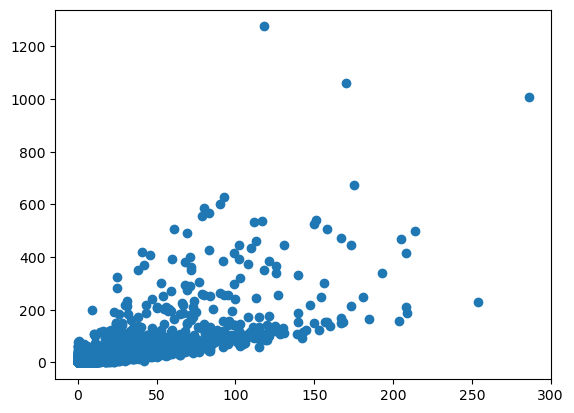

In [13]:
plt.scatter(spotcount.iloc[:,0], 
            spotcount_intn.iloc[:,0],
           )

In [14]:
def plot_reverse_cumsum(counts, bins=np.arange(0,11,1)):
    """
    """
    cnts, bins = np.histogram(counts, bins)
    fig, ax = plt.subplots()
    ax.plot(bins[1:], len(counts)-np.cumsum(cnts), '-o')
    ax.set_xlabel('num spots')
    ax.set_ylabel('num cells (cumulative)')

    ax2 = ax.twinx()
    ax2.plot(bins[1:], (len(counts)-np.cumsum(cnts))/len(counts), '-o')
    ax2.set_ylabel('fraction of cells')
    
    return fig

28228 11453 6097


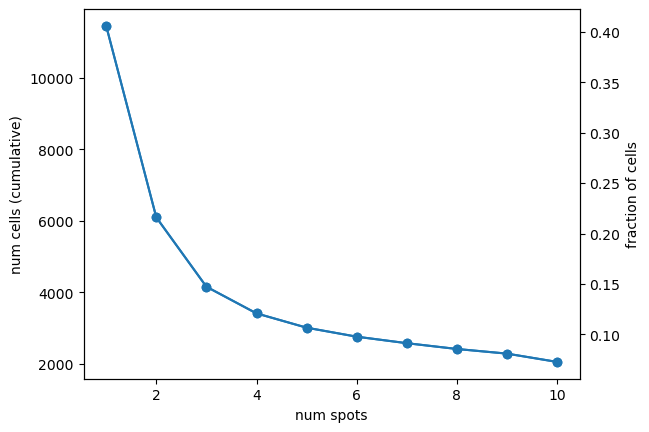

In [15]:
counts = spotcount.iloc[:,0]
print(len(counts), (counts>=1).sum(), (counts>=2).sum())

fig = plot_reverse_cumsum(counts)

In [16]:
table = roi_meta.join(spotcount) #_merged)
table = table.join(spotcount_intn, lsuffix='', rsuffix='_intn') #_merged)
table

z           y           x         area  r1_c0  r1_c0_intn
roi                                                                      
1      223.381698  118.023524  345.738751  2663.316096   27.0   17.598866
2      168.712415  365.227001  155.285191  3824.339904   65.0  103.534291
3      354.251797  140.049249  504.988163  2813.332032    1.0    0.000000
4      498.298442  165.682851   64.912608  2573.733120    0.0    0.000000
5      181.096767   71.323709  379.952383  3434.725056    2.0   16.787883
...           ...         ...         ...          ...    ...         ...
28224   82.788737  479.759067  898.320341  1249.895808    0.0    0.000000
28225  280.886322  481.080502  796.140414   962.661504    0.0    4.187752
28226  317.530425  538.178367  492.551535  1088.504256    0.0    0.000000
28227   92.072529  253.880894  134.486927  2927.088192    0.0    0.000000
28228  229.877528  308.873387  182.145233   885.876096    0.0    5.222640

[28228 rows x 6 columns]

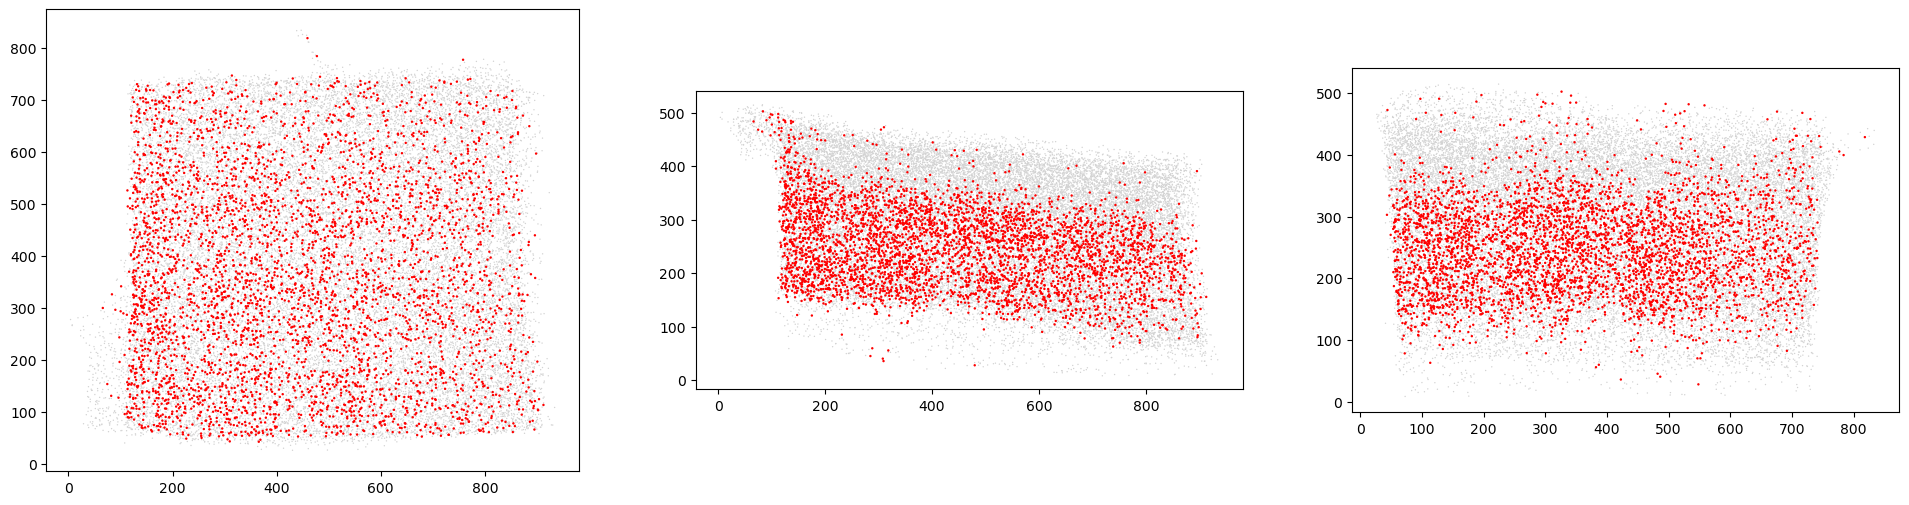

In [17]:
cond = table['r1_c0']>2

fig, axs = plt.subplots(1, 3, figsize=(3*8,1*6))
ax = axs[0]
g = ax.scatter(table['x'], table['y'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['x'][cond], table['y'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')

ax = axs[1]
g = ax.scatter(table['x'], table['z'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['x'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')

ax = axs[2]
g = ax.scatter(table['y'], table['z'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['y'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')
plt.show()

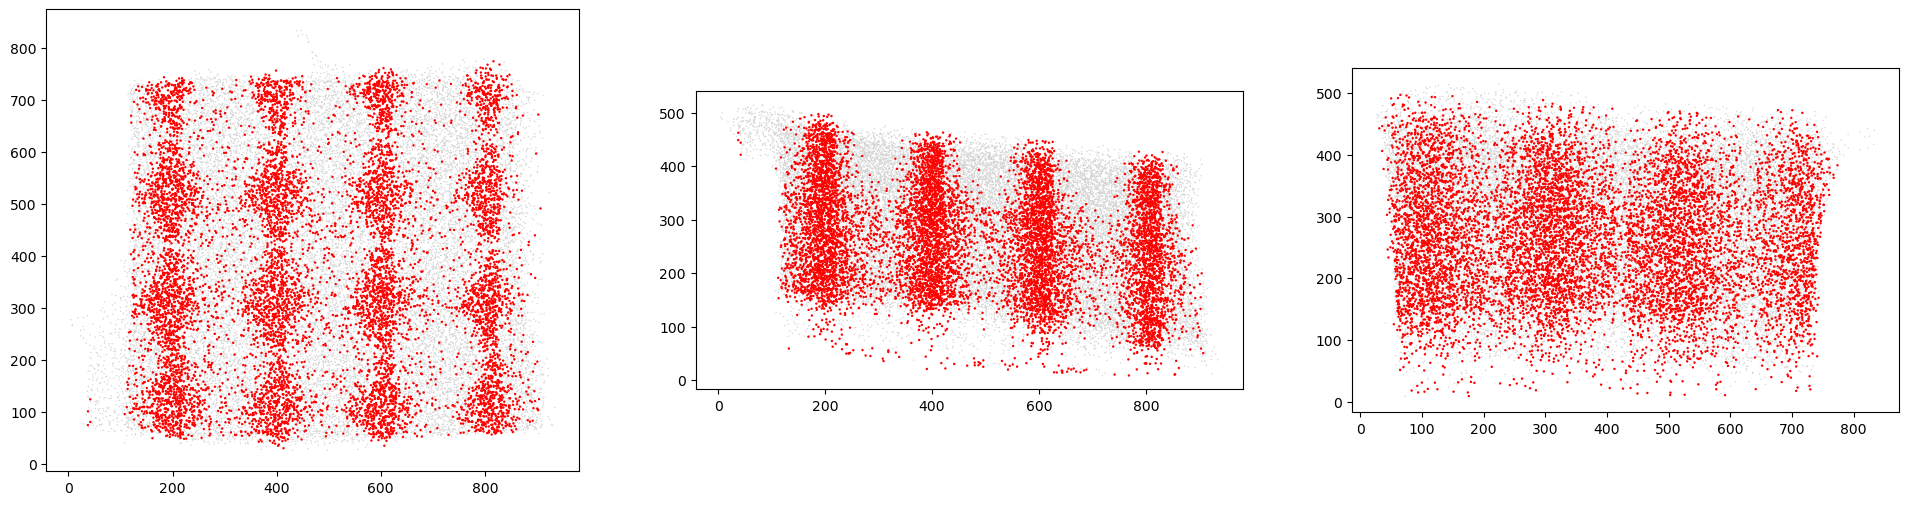

In [18]:

cond = table['r1_c0_intn']>5

fig, axs = plt.subplots(1, 3, figsize=(3*8,1*6))
ax = axs[0]
g = ax.scatter(table['x'], table['y'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['x'][cond], table['y'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')

ax = axs[1]
g = ax.scatter(table['x'], table['z'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['x'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')

ax = axs[2]
g = ax.scatter(table['y'], table['z'], c='lightgray', s=1, edgecolor='none')
g = ax.scatter(table['y'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
# fig.colorbar(g, shrink=0.3)
ax.set_aspect('equal')
plt.show()

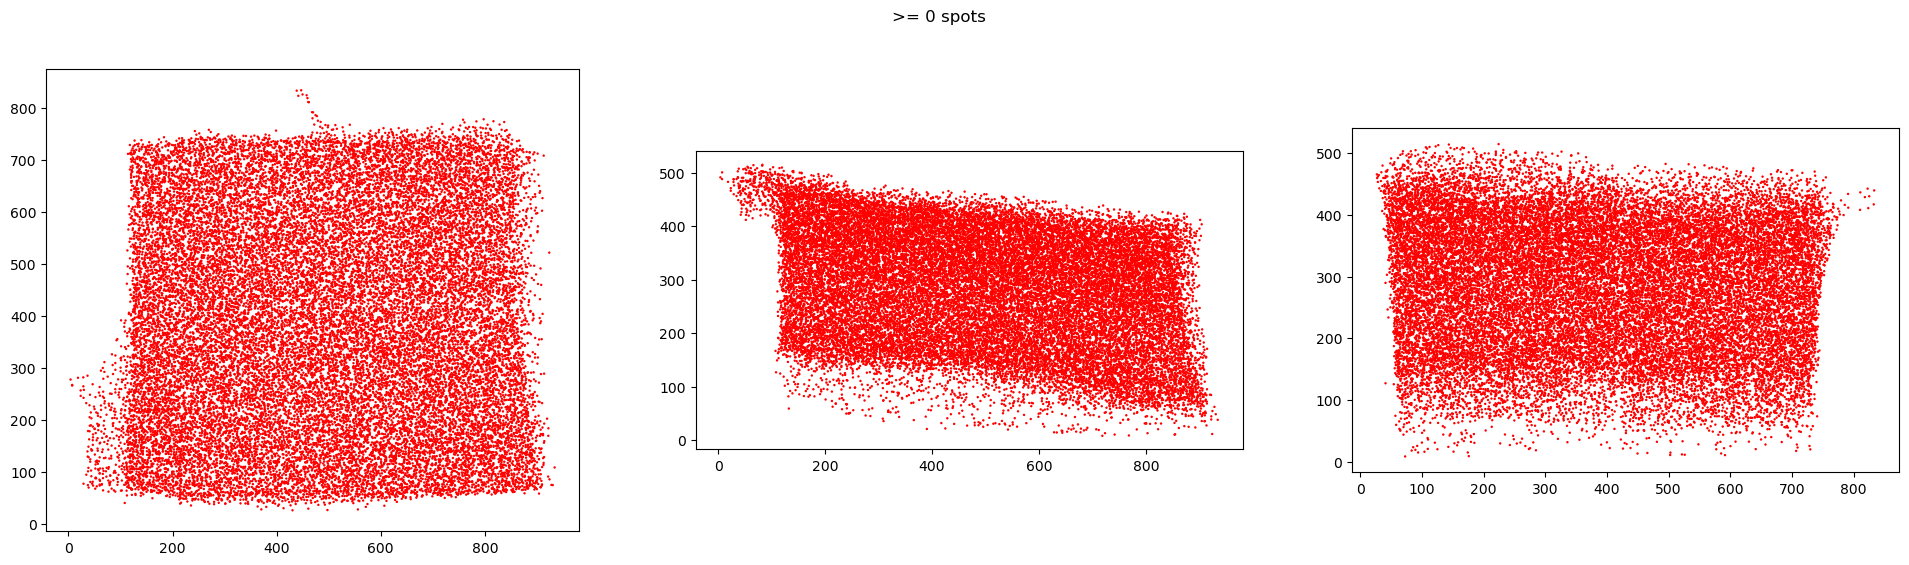

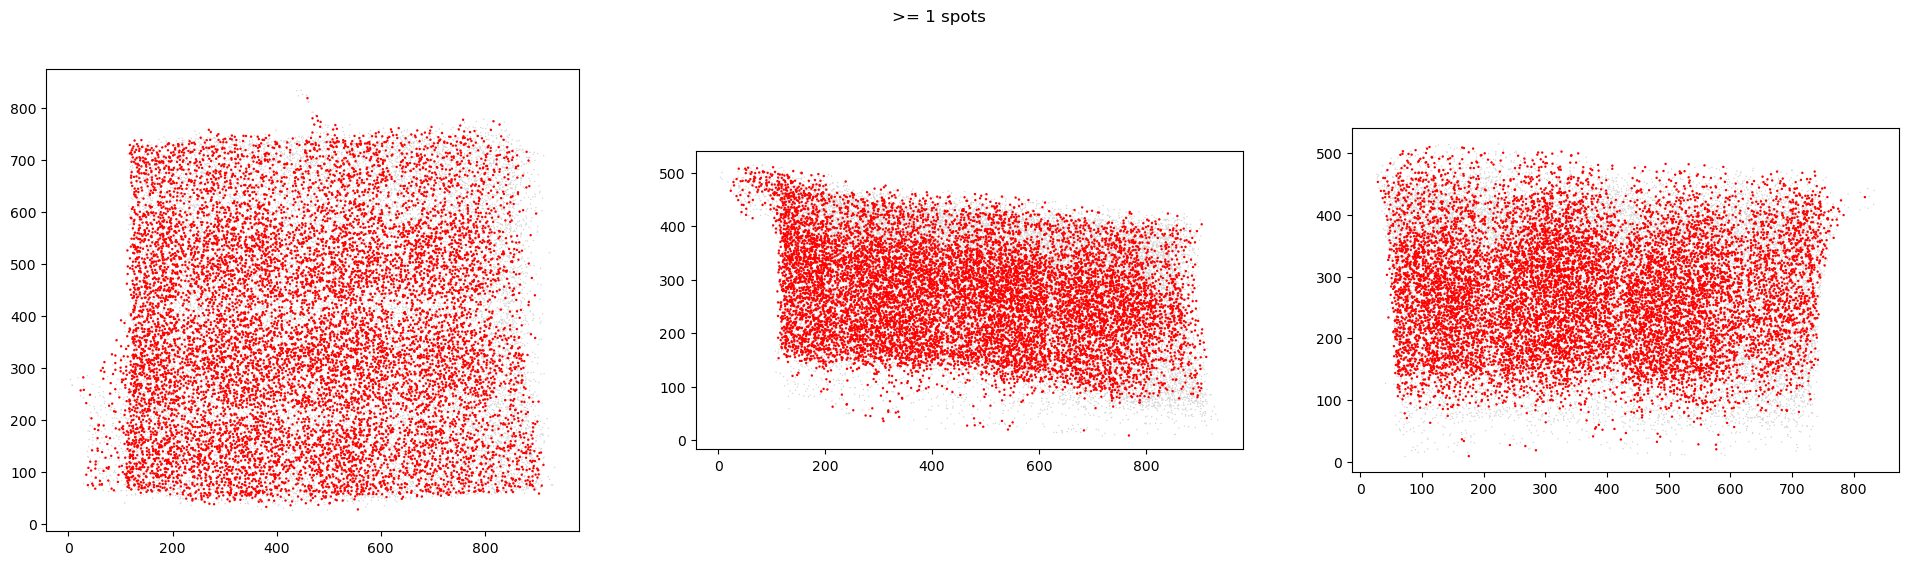

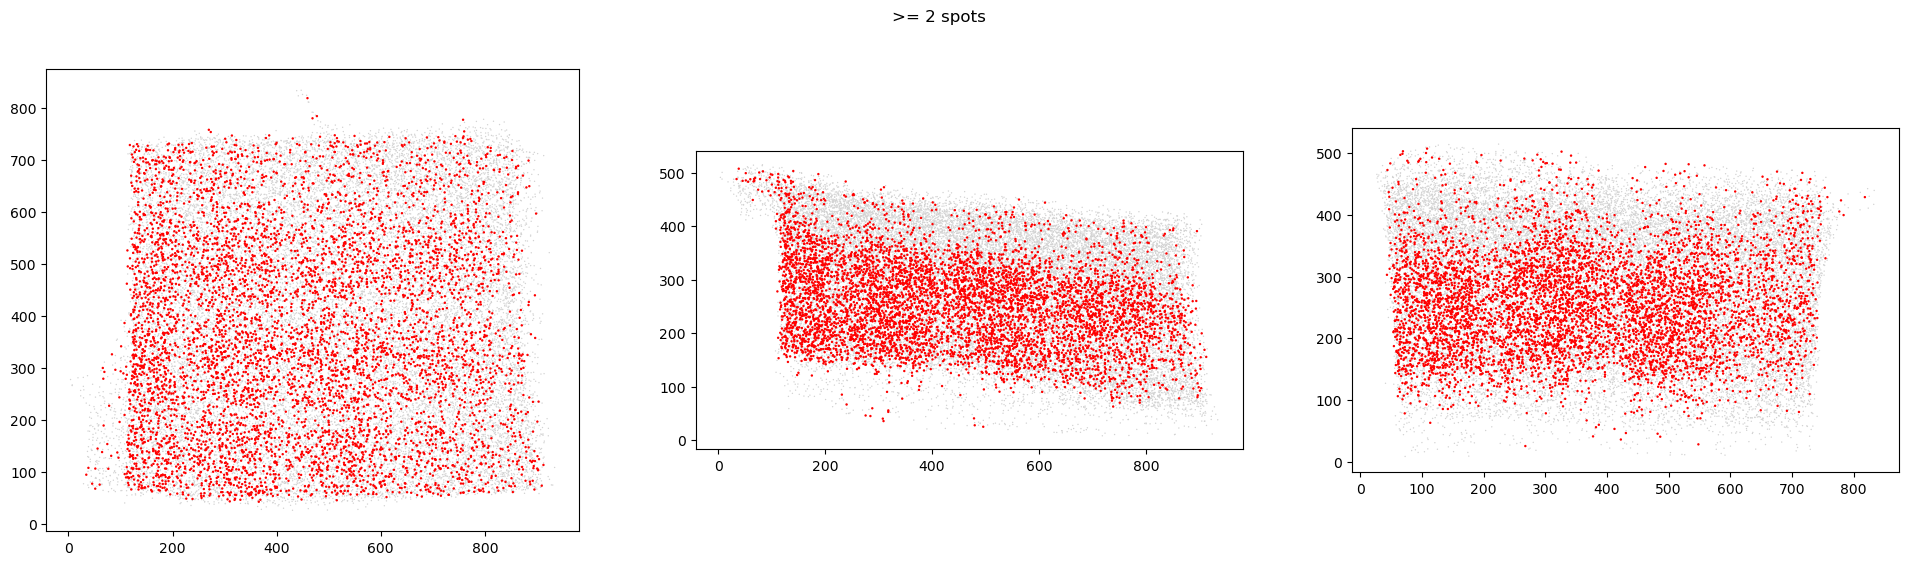

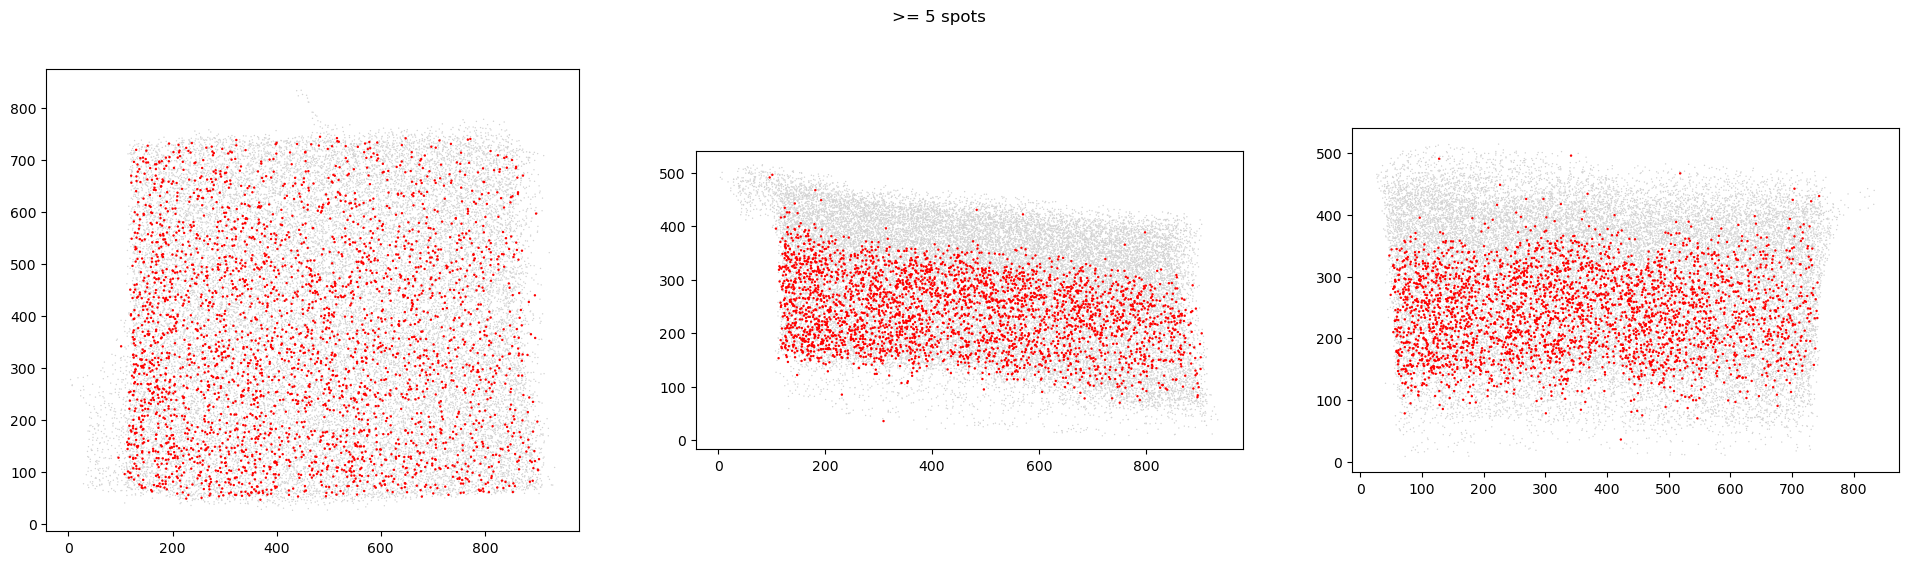

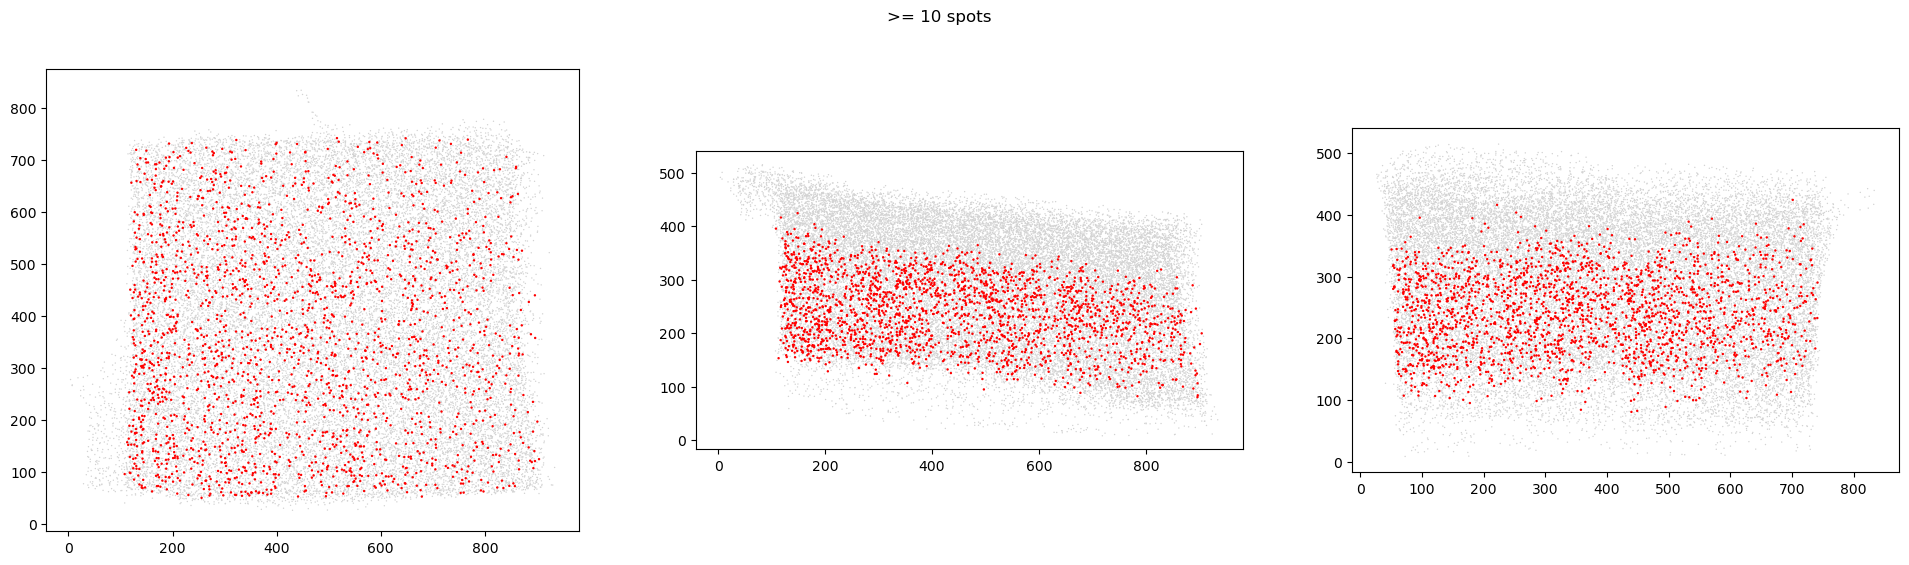

In [19]:

for i in [0, 1,2,5,10]:
    cond = table['r1_c0']>=i
    
    fig, axs = plt.subplots(1, 3, figsize=(3*8,1*6))
    fig.suptitle(f">= {i} spots")
    ax = axs[0]
    g = ax.scatter(table['x'], table['y'], c='lightgray', s=1, edgecolor='none')
    g = ax.scatter(table['x'][cond], table['y'][cond], c='red', s=3, edgecolor='none')
    # fig.colorbar(g, shrink=0.3)
    ax.set_aspect('equal')

    ax = axs[1]
    g = ax.scatter(table['x'], table['z'], c='lightgray', s=1, edgecolor='none')
    g = ax.scatter(table['x'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
    # fig.colorbar(g, shrink=0.3)
    ax.set_aspect('equal')

    ax = axs[2]
    g = ax.scatter(table['y'], table['z'], c='lightgray', s=1, edgecolor='none')
    g = ax.scatter(table['y'][cond], table['z'][cond], c='red', s=3, edgecolor='none')
    # fig.colorbar(g, shrink=0.3)
    ax.set_aspect('equal')
    plt.show()
